In [2]:
import numpy as np
import pickle
import glob
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

file_path = '/export/home/qliu24/qing_voting_data/qing_intermediate/feat_pickle/'
oo = 'train'
fname = file_path + 'res_info_{0}_train.pickle'.format(oo)
with open(fname, 'rb') as fh:
    layer_feature_dist, _, view_point = pickle.load(fh)
    
'''
filename = '/media/zzs/4TB/qingliu/qing_intermediate/all_K216_res_info/res_info_car_train.mat'
f = h5py.File(filename)
dic1 = f['res_info']
len1 = dic1.shape[0]

layer_feature_dist = [None for nn in range(len1)]
for nn in range(len1):
    dic2 = f[dic1[nn,0]]
    dic21 = dic2["layer_feature_dist"]
    dic21 = np.array(dic21)
    layer_feature_dist[nn] = dic21
    
print(layer_feature_dist[0].shape)
'''

N=len(view_point)
magic_thh = 0.67

layer_feature_b = [None for nn in range(N)]
for nn in range(N):
    layer_feature_b[nn] = (layer_feature_dist[nn]<magic_thh).astype(int)
    
# VC num
max_0 = max([layer_feature_b[nn].shape[0] for nn in range(N)])
# width
max_1 = max([layer_feature_b[nn].shape[1] for nn in range(N)])
# height
max_2 = max([layer_feature_b[nn].shape[2] for nn in range(N)])
print(max_0, max_1, max_2)

all_train = []
for nn in range(N):
    vnum, ww, hh = layer_feature_b[nn].shape
    assert(vnum == max_0)
    diff_w1 = int((max_1-ww)/2)
    diff_w2 = int(max_1-ww-diff_w1)
    assert(max_1 == diff_w1+diff_w2+ww)
    
    diff_h1 = int((max_2-hh)/2)
    diff_h2 = int(max_2-hh-diff_h1)
    assert(max_2 == diff_h1+diff_h2+hh)
    
    padded = np.pad(layer_feature_b[nn], ((0,0),(diff_w1, diff_w2),(diff_h1, diff_h2)), 'constant', constant_values=0)
    all_train.append(np.pad(layer_feature_b[nn], ((0,0),(diff_w1, diff_w2),(diff_h1, diff_h2)), \
                            'constant', constant_values=0).ravel())
    
all_train = np.array(all_train)
print(all_train.shape)

ModuleNotFoundError: No module named 'matplotlib'

In [22]:
from mixture_model_funcs import compt_weights, compt_lbs
cls_num = 4
max_iter = 5000
tol = 1e-6
report_iter = 2
start_way = 2
# 0: rand start
# 1: hard start
# 2: soft start

dat_i = all_train.T
lbs_b = np.zeros((cls_num, dat_i.shape[1]))
if start_way == 0:
    if cls_num==1:
        print('Unary model!')
        lbs_b = np.ones((1, dat_i.shape[1]))
    else:
        lbs_b = np.random.uniform(size=(lbs_b.shape))
        lbs_b = lbs_b/np.sum(lbs_b,axis=0)
else:
    fname = '/media/zzs/4TB/qingliu/qing_intermediate/unary_weights/{0}_k2_2_lbs.pickle'.format(oo)
    with open(fname, 'rb') as fh:
        lbs = pickle.load(fh)
        
    if start_way == 1:
        for kki in range(cls_num):
            lbs_b[kki,lbs==kki] = 1.
        
    elif start_way == 2:
        for kki in range(cls_num):
            lbs_b[kki,lbs==kki] = 0.5
            lbs_b[kki,lbs!=kki] = 0.5/(cls_num-1)
            
weights = compt_weights(lbs_b, dat_i)  # init weights
lbs_prior = np.sum(lbs_b, axis=1)/np.sum(lbs_b)  # init label prior
log_marg_ls = []
for iit in range(max_iter):
    lbs_b2, log_marg = compt_lbs(weights, dat_i, lbs_prior)
    weights = compt_weights(lbs_b2, dat_i)
    lbs_prior = np.sum(lbs_b2, axis=1)/np.sum(lbs_b2)
    log_marg_ls.append(log_marg)
    try:
        assert(np.all(np.sum(lbs_b2, axis=0)>0.9999))
    except:
        print(lbs_b2[:,0:10])
        sys.exit('error')
        
    if (iit+1)%report_iter==0:
        print('lbs_prior')
        print(lbs_prior)
        print('iter {0}: log marginal likelihood {1}, training set'.format(iit, log_marg))
        
    if len(log_marg_ls)>=2 and np.absolute(log_marg_ls[-1] - log_marg_ls[-2])<tol:
        print('lbs_prior')
        print(lbs_prior)
        print('iter {0}: log marginal likelihood {1}, training set'.format(iit, log_marg))
        print('early stop.')
        break

lbs_prior
[ 0.32727273  0.36767677  0.15757576  0.14747475]
iter 1: log marginal likelihood -2584.3852345985683, training set
lbs_prior
[ 0.32727273  0.36767677  0.15757576  0.14747475]
iter 3: log marginal likelihood -2583.9266376432843, training set
lbs_prior
[ 0.32727273  0.36767677  0.15757576  0.14747475]
iter 3: log marginal likelihood -2583.9266376432843, training set
early stop.


Car K4:
soft_start:
lbs_prior
[ 0.316  0.232  0.327  0.125]
iter 3: log marginal likelihood -3044.3463488350217, training set
early stop.

rand_start:
lbs_prior
[ 0.33999997  0.36100004  0.126       0.173     ]
iter 25: log marginal likelihood -3070.1684017487705, training set
early stop.

Bus K4:
soft_start:
lbs_prior
[ 0.40038685  0.2688588   0.15473888  0.17601547]
iter 3: log marginal likelihood -2741.853971742584, training set
early stop.

Aeroplane K4:
soft_start:
lbs_prior
[ 0.16018846  0.18138987  0.37102474  0.28739694]
iter 6: log marginal likelihood -3031.037423166846, training set
early stop.

Bicycle K4:
soft_start:
lbs_prior
[ 0.33780161  0.11260054  0.27077748  0.27882038]
iter 3: log marginal likelihood -1783.009328609618, training set
early stop.

Motorbike K4:
soft_start:
lbs_prior
[ 0.22857143  0.39047619  0.19047619  0.19047619]
iter 2: log marginal likelihood -1847.9404086487368, training set
early stop.

Train K4:
soft_start:
lbs_prior
[ 0.32727273  0.36767677  0.15757576  0.14747475]
iter 3: log marginal likelihood -2583.9266376432843, training set
early stop.

Car K4:
hard_start:
iter 4: log marginal likelihood -3132.664051120876, training set
early stop.

soft_start:
iter 3: log marginal likelihood -3130.8981571400454, training set
early stop.

rand_start:
iter 42: log marginal likelihood -3157.1479323400204, training set
early stop.

Bus K4:
hard_start:
iter 1: log marginal likelihood -2801.7248324999027, training set
early stop.

soft_start:
iter 3: log marginal likelihood -2799.653912153854, training set
early stop.

rand_start:
iter 6: log marginal likelihood -2937.505599662498, training set
early stop.

Aeroplane K4:
rand_start:
iter 19: log marginal likelihood -3428.8521101083124, training set
early stop.

hard_start:
iter 13: log marginal likelihood -3331.955700192214, training set
early stop.

soft_start:
iter 13: log marginal likelihood -3331.2100743420633, training set
early stop.

train K4:
rand_start:
iter 5: log marginal likelihood -2744.106572778793, training set
early stop.

hard_start:
iter 1: log marginal likelihood -2678.0328019428225, training set
early stop.

soft_start:
iter 4: log marginal likelihood -2676.638589155736, training set
early stop.

Bicycle K4:
rand_start:
iter 6: log marginal likelihood -1873.8589404774686, training set
early stop.

hard_start:
iter 1: log marginal likelihood -1745.777829110655, training set
early stop.

soft_start:
iter 2: log marginal likelihood -1745.777829110655, training set
early stop.

Motorbike K4:
rand_start:
iter 4: log marginal likelihood -1871.250354778196, training set
early stop.

hard_start:
iter 1: log marginal likelihood -1795.8305321992686, training set
early stop.

soft_start:
iter 2: log marginal likelihood -1795.8305321992686, training set
early stop.

In [23]:
np.max(lbs_b2[:,0:10],axis=0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [24]:
import scipy.io as sio
sio.savemat('/media/zzs/4TB/qingliu/qing_intermediate/unary_weights/{0}_K{1}_softstart.mat'.format(oo,cls_num), \
            mdict={'mixture_weights':weights, 'mixture_priors':lbs_prior})

In [ ]:
f, axes = plt.subplots(1,cls_num, sharex=True, sharey=True, figsize=(8,3))
axes[0].set_xlim([0,360])
axes[0].set_xticks([0,90,180,270,360])

for k in range(cls_num):
    axes[k].hist(np.array(view_point)[lbs_b2[k]>0.99], bins=8, range=[0,360], facecolor='green', alpha=0.75,edgecolor='k')

plt.show()

fname = '/media/zzs/4TB/qingliu/qing_intermediate/unary_weights/{0}_k2_2_lbs.pickle'.format(oo)
with open(fname, 'rb') as fh:
    lbs = pickle.load(fh)
    
f, axes = plt.subplots(1,cls_num, sharex=True, sharey=True, figsize=(8,3))
axes[0].set_xlim([0,360])
axes[0].set_xticks([0,90,180,270,360])

for k in range(cls_num):
    axes[k].hist(np.array(view_point)[lbs==k], bins=8, range=[0,360], facecolor='green', alpha=0.75,edgecolor='k')

plt.show()

(3549, 3549)
loading object car
total number of instances 1000
[[ 1.          0.91862003  0.92933145  0.97097748  0.77614145  0.88174114
   0.91224609  0.94796324  0.87137262  0.97009701]
 [ 0.91862003  1.          0.96065876  0.79307085  0.7874183   0.86632377
   0.88264927  0.92879863  0.76577741  0.9656752 ]
 [ 0.92933145  0.96065876  1.          0.97174319  0.94986631  0.89825802
   0.8747222   0.97362584  0.96519484  0.93574815]
 [ 0.97097748  0.79307085  0.97174319  1.          0.89258578  0.83955042
   0.71089672  0.99211376  0.83272958  0.92574257]
 [ 0.77614145  0.7874183   0.94986631  0.89258578  1.          0.95819383
   0.93555473  0.96338234  0.41116089  0.92252177]
 [ 0.88174114  0.86632377  0.89825802  0.83955042  0.95819383  1.
   0.89876889  0.92660872  0.95773398  0.95020774]
 [ 0.91224609  0.88264927  0.8747222   0.71089672  0.93555473  0.89876889
   1.          1.          0.91906246  0.91108618]
 [ 0.94796324  0.92879863  0.97362584  0.99211376  0.96338234  0.92660

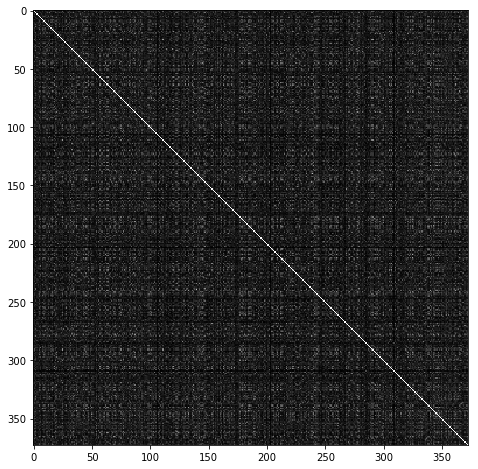

In [28]:
file_path = '/media/zzs/4TB/qingliu/qing_intermediate/feat_pickle/'
fname = file_path + 'all_simmat.pickle'
with open(fname, 'rb') as fh:
    mat_dis1, mat_dis2 = pickle.load(fh)
    
print(mat_dis1.shape)

asp_ratio = []
types = []
view_point = []
oo='car'
fname = file_path + 'res_info_' + oo + '_train.pickle'
print('loading object {0}'.format(oo))
with open(fname, 'rb') as fh:
    l, _, v = pickle.load(fh)
    types += [oo for ii in range(len(v))]
    view_point += v
    asp_ratio += [l[ii].shape[1]/l[ii].shape[2] for ii in range(len(v))]
    
N = len(types)
print('total number of instances {0}'.format(N))

mat_dis = mat_dis1[0:N, 0:N]
mat_full = np.ones_like(mat_dis)
for nn in range(mat_full.shape[0]):
    mat_full[nn] = np.append(mat_dis[0:nn, nn], mat_dis[nn, nn:])
    
print(mat_full[0:10,0:10])

np.fill_diagonal(mat_full, 0)

W_mat = 1. - mat_full
print(np.mean(W_mat))
print(np.std(W_mat))



_idx = np.array([]).astype(int)
for kk in range(4):
    iidx = np.where(lbs==kk)[0]
    _idx = np.append(_idx, iidx)
    
grid_ix = np.ix_(_idx, _idx)
plt.close()
plt.imshow(W_mat[grid_ix], interpolation='none')
plt.show()

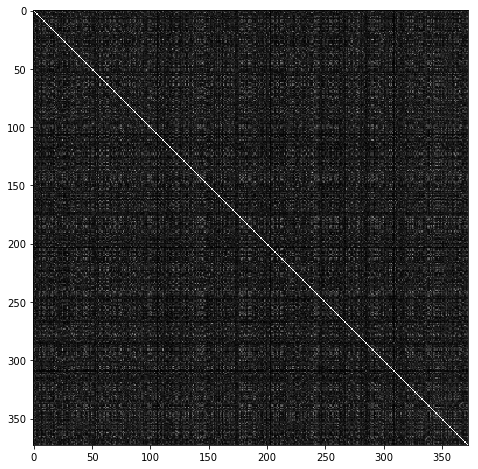

In [29]:
_idx = np.array([]).astype(int)
for kk in range(4):
    iidx = np.where(lbs_b2[kk]>0.99)[0]
    _idx = np.append(_idx, iidx)
    
grid_ix = np.ix_(_idx, _idx)
plt.close()
plt.imshow(W_mat[grid_ix], interpolation='none')
plt.show()